# Midterm Project: Heart Disease Health Indicators

In [1]:
# make all necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from catboost import CatBoostClassifier, Pool

# read in the data
data = pd.read_csv('data.csv')
    
# separate the labels from the data
labels = data.pop('HeartDiseaseorAttack')

Apply variable transformations to BMI, MentHlth, and PhysHlth.

In [2]:
# convert BMI
for i in range(len(data)):
    if data.loc[i]['BMI'] <  18.5:
        data.loc[i]['BMI'] = 1
    elif 18.5 <= data.loc[i]['BMI'] < 25:
        data.loc[i]['BMI'] = 2
    elif 25 <= data.loc[i]['BMI'] < 30:
        data.loc[i]['BMI'] = 3
    elif 30 <= data.loc[i]['BMI'] < 35:
        data.loc[i]['BMI'] = 4
    elif 35 <= data.loc[i]['BMI'] < 40:
        data.loc[i]['BMI'] = 5
    else:
        data.loc[i]['BMI'] = 6
        
# convert MentHlth
for i in range(len(data)):
    if data.loc[i]['MentHlth'] <= 5 :
        data.loc[i]['MentHlth'] = 1
    elif 5 < data.loc[i]['MentHlth'] <= 11:
        data.loc[i]['MentHlth'] = 2
    elif 11 < data.loc[i]['MentHlth'] <= 17:
        data.loc[i]['MentHlth'] = 3
    elif 17 < data.loc[i]['MentHlth'] <= 23:
        data.loc[i]['MentHlth'] = 4
    else:
        data.loc[i]['MentHlth'] = 5

# convert PhysHlth
for i in range(len(data)):
    if data.loc[i]['PhysHlth'] <= 5:
        data.loc[i]['PhysHlth'] = 1
    elif 5 < data.loc[i]['PhysHlth'] <= 11:
        data.loc[i]['PhysHlth'] = 2
    elif 11 < data.loc[i]['PhysHlth'] <= 17:
        data.loc[i]['PhysHlth'] = 3
    elif 17 < data.loc[i]['PhysHlth'] <= 23:
        data.loc[i]['PhysHlth'] = 4
    else:
        data.loc[i]['PhysHlth'] = 5

Now separate the data.

In [3]:
# split the data and labels into training and validation
training_data, validation_data, training_labels, validation_labels = train_test_split(data, labels,
                                                                                train_size=0.8, random_state=69)

# Pool the training and validation datasets for later
training_dataset = Pool(data = training_data, label = training_labels)
validation_dataset = Pool(data = validation_data, label = validation_labels)

## Model 1: No Specified Class Weights

Instantiate the model.

In [4]:
# initialize and fit the model using the training and validation sets using default parameters
cboost = CatBoostClassifier(loss_function = 'Logloss', custom_loss = ['Accuracy'], logging_level = 'Silent', \
                            random_seed=69)

# cboost.fit(training_dataset, eval_set = (validation_dataset))
cboost.fit(training_dataset, eval_set = validation_dataset)

Make predictions

In [5]:
# make the predictions using the optimal model
predictions = cboost.predict(data).flatten()

Check predicion accuracy

In [6]:
np.unique(labels, return_counts = True)[1][1]

23893

In [7]:
# evaluation function: display the confusion matrix of the predicitons vs actual labels
def class_res(testing_labels, predictions, labels):
    print('Overall accuracy: ' + str(accuracy_score(testing_labels, predictions))+'%')
    acc = confusion_matrix(testing_labels, predictions)
    accframe = pd.DataFrame(data = acc, index = ['Actually 0', 'Actually 1'], \
                            columns = ['Predicted 0', 'Predicted 1'])
    print('Portion of heart disease cases caught: ' + str(accframe.loc['Actually 1']['Predicted 1'] / \
                                       np.unique(labels, return_counts = True)[1][1]))
    display(accframe)
    
class_res(labels, predictions, labels)

Overall accuracy: 0.9101190476190476%
Portion of heart disease cases caught: 0.11040890637425187


,Predicted 0,Predicted 1
Actually 0,228241,1546
Actually 1,21255,2638


Get feature importance.

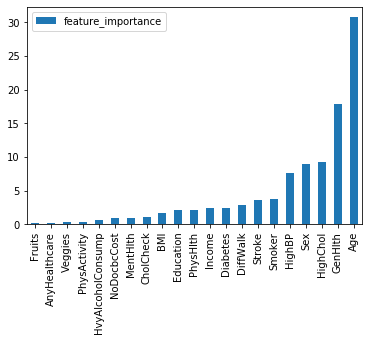

In [8]:
feat_frame = pd.DataFrame({'feature_importance': cboost.get_feature_importance(training_dataset)}, \
                          index = training_data.columns).sort_values(by=['feature_importance'],ascending = True)
feat_frame.plot.bar()

In [9]:
cboost.get_feature_importance(training_dataset)

array([ 7.67539124,  9.2178088 ,  1.0762452 ,  1.63123724,  3.69405923,
        3.5692512 ,  2.47533032,  0.35946763,  0.17897053,  0.34951036,
        0.6596485 ,  0.20566005,  0.90967888, 17.89949404,  0.93169698,
        2.12693455,  2.90028105,  8.92197326, 30.76730915,  2.05718687,
        2.39286495])

## Model 2: Specified Class Weights

Instantiate a new classifier.

In [10]:
# initialize and fit the model using the training and validation sets using default parameters
cboost1 = CatBoostClassifier(loss_function = 'Logloss', custom_loss = ['Accuracy'], logging_level = 'Silent', \
                            class_weights=[1, 10], random_seed=69)

# cboost.fit(training_dataset, eval_set = (validation_dataset))
cboost1.fit(training_dataset, eval_set = validation_dataset)

Make predictions.

In [11]:
predictions1 = cboost1.predict(data).flatten()

Check prediction accuracy.

In [12]:
class_res(labels, predictions1, labels)

Overall accuracy: 0.7365302743614002%
Portion of heart disease cases caught: 0.8337588415016951


,Predicted 0,Predicted 1
Actually 0,166922,62865
Actually 1,3972,19921


Get feature importance.

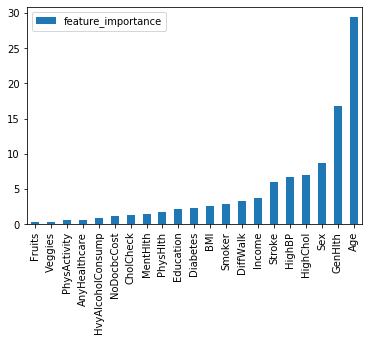

In [13]:
feat_frame1 = pd.DataFrame({'feature_importance': cboost1.get_feature_importance(training_dataset)}, \
                          index = training_data.columns).sort_values(by=['feature_importance'],ascending = True)
feat_frame1.plot.bar()

In [14]:
cboost1.get_feature_importance(training_dataset)

array([ 6.71786088,  6.99231587,  1.34620052,  2.64945508,  2.90739442,
        6.00893391,  2.33212873,  0.55572695,  0.36109163,  0.38424574,
        0.87443331,  0.5828778 ,  1.11689001, 16.79729619,  1.42109379,
        1.74076289,  3.30106628,  8.66518262, 29.400498  ,  2.13054827,
        3.71399711])